In [1]:
#install
!pip install -U scikit-learn

#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

#buat random seed menggunakan numpy dan tensorflow
np.random.seed(123)
tf.random.set_seed(123)

#download file
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

#buat dataframe
df0 = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

#buat dataframe salinan/modifikasi (berbeda dari dataframe di atas)
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

#buat kolom baru
df['LogClose'] = np.log(df['Close'])
df['DiffLogClose'] = df['LogClose'].diff()

#buat variable untuk data training dan testing
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

#buat scaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

#buat variable yang akan berisi nilai boolean
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

#buat kolom baru
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

     |████████████████████████████████| 24.8 MB 27.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
--2022-01-09 22:10:09--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘sp500sub.csv’

sp500sub.csv        100%[===================>]  24.29M  1.13MB/s    in 14s     

2022-01-09 22:10:24 (1.69 MB/s) - ‘sp500sub.csv’ saved [25473876/25473876]



In [5]:
#buat supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()

#buat variable dan array
T = 10
X = []
Y = []

#buat perulangan
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

#buat variable untuk menampung nilai array dari hasil perulangan
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)

#display
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


Epoch 1/200
70/70 [==============================] - 1s 4ms/step - loss: 1.2007 - val_loss: 1.0208
Epoch 2/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0575 - val_loss: 0.9873
Epoch 3/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0324 - val_loss: 0.9807
Epoch 4/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0160 - val_loss: 0.9870
Epoch 5/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0058 - val_loss: 0.9779
Epoch 6/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9959 - val_loss: 0.9783
Epoch 7/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9871 - val_loss: 0.9868
Epoch 8/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9807 - val_loss: 0.9754
Epoch 9/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9754 - val_loss: 0.9974
Epoch 10/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9711 - val_loss: 0.9977
Epoch 11/

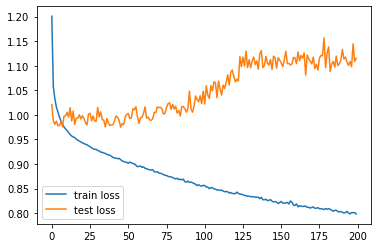

In [6]:
#buat variable data training dan testing
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

#buat model basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

#buat compiler model
model.compile(
  loss='mse',
  optimizer='adam',
)

#buat fit model
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=200,
  validation_data=(Xtest, Ytest)
)

#buat plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

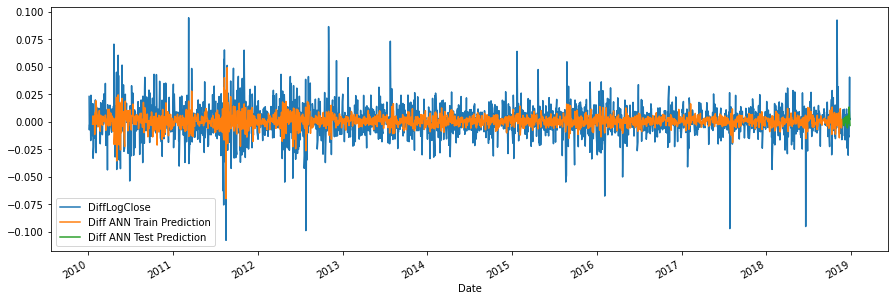

In [7]:
train_idx[:T+1] = False # nilai T+1 pertama tidak diprediksi

#buat variable array untuk menampung nilai dari hasil prediksi
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

#buat variable array untuk menampung scaler array diatas
Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

#buat menyipan data diff prediksi
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

#buat plot
cols = ['DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5));

In [8]:
#dibutuhkan untuk menghitung data yang diprediksi tidak berbeda
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

#buat variable untuk mengetahui nilai terakhir dari data training
last_train = train.iloc[-1]['LogClose']

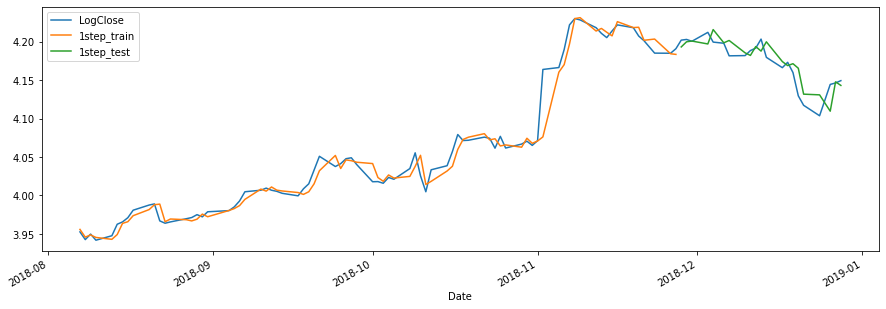

In [9]:
#1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

#buat plot 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize=(15, 5));

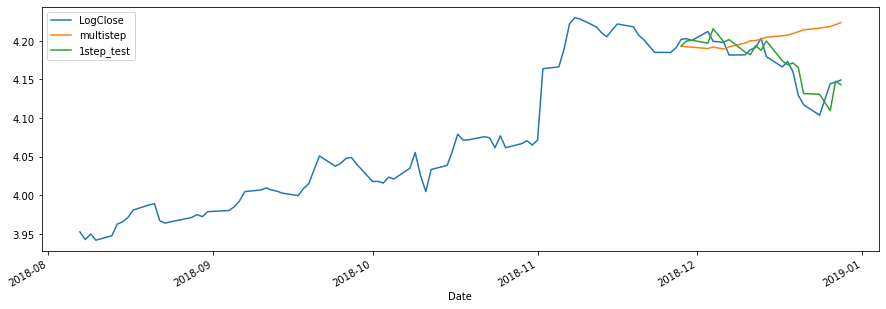

In [10]:
#baut multi-step forecast
multistep_predictions = []

#input data testing pertama
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]
  
  #update list prediksi
  multistep_predictions.append(p)
  
  #buat inputan baru
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

#unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()

#simpan multi-step forecast ke dalam dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

#buat plot 1-step dan multi-step forecast
df.iloc[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [11]:
#buat multi-output supervised dataset

#buat variable
Tx = T
Ty = Ntest

#buat array
X = []
Y = []

#buat perulangan
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2232, 10) Y.shape (2232, 21)


Epoch 1/100
70/70 [==============================] - 1s 6ms/step - loss: 1.1648 - val_loss: 0.9367
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0706 - val_loss: 0.9638
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0391 - val_loss: 0.9691
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0235 - val_loss: 0.9874
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0147 - val_loss: 0.9897
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0089 - val_loss: 0.9942
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0047 - val_loss: 1.0066
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0016 - val_loss: 1.0062
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9991 - val_loss: 1.0111
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9973 - val_loss: 1.0018
Epoch 11/

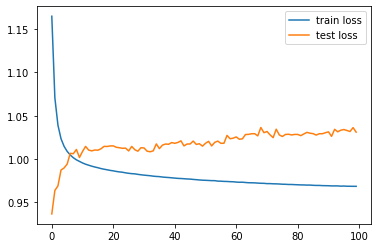

In [15]:
#buat variable untuk data training dan testing
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

#buat model basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

#buat compiler
model.compile(
  loss='mse',
  optimizer='adam',
)

#buat fit model
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=100,
  validation_data=(Xtest_m, Ytest_m)
)

#Buat plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

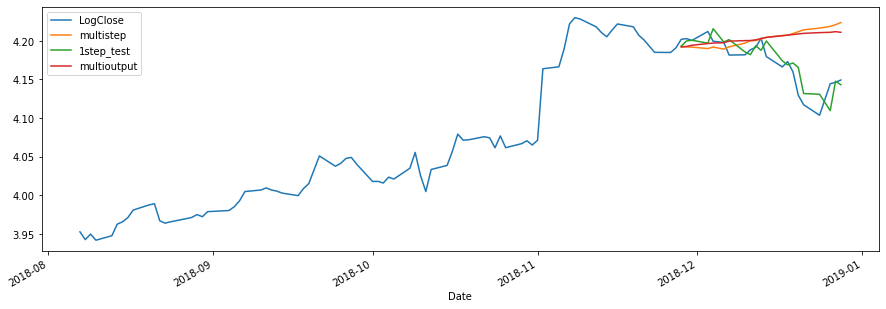

In [16]:
#buat variable
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

#unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

#simpan multi-output forecast ke dalam dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

#buat plot semua forecasts
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [17]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.008941029893924412
multi-output MAPE: 0.00831916054827817


# 1-step Binary Classification

Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.7292 - accuracy: 0.5034 - val_loss: 0.6436 - val_accuracy: 0.5714
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7068 - accuracy: 0.5043 - val_loss: 0.6678 - val_accuracy: 0.5238
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6998 - accuracy: 0.5069 - val_loss: 0.6760 - val_accuracy: 0.5238
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5052 - val_loss: 0.6880 - val_accuracy: 0.5238
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5034 - val_loss: 0.6873 - val_accuracy: 0.5238
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5034 - val_loss: 0.6893 - val_accuracy: 0.5238
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5025 - val_loss: 0.6868 - val_accuracy: 0.5238
Epoch 8/100
7

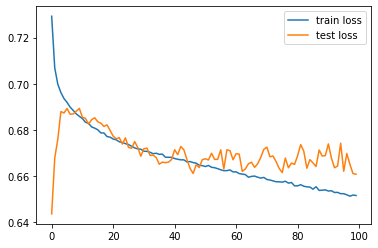

In [18]:
#buat variable
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

#buat model basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

#buat compiler
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

#buat fit model
r = model.fit(
  Xtrain,
  Ytrain_b,
  epochs=100,
  validation_data=(Xtest, Ytest_b)
)

#buat plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

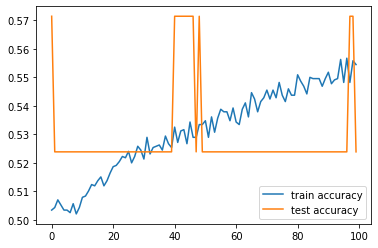

In [19]:
#buat plot
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();